<a href="https://colab.research.google.com/github/a-parida12/furry-octo-spork/blob/main/LungSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands on ML Segmentation Session

The purpose of the notebook is to follow the lifecycle of creating a deep learning based algorithm for the task of segmentation. The task we will focus on is the segmentation of the left and right lungs in a CXR image.

We will be using the data from the kaggle dataset from the CXR segmentation challenge

# Getting The Playground Ready

Some of the steps to get the colab ready. In this section we will download the data from the kaggle and make the colab enviornment ready for the further tasks

In [ ]:
import os
from pathlib import Path
from glob import glob
from collections import defaultdict
import pandas as pd
import re

import matplotlib.pyplot as plt
import cv2

# configure the kaggle downloader api
path_to_json = '/content/kaggle.json'
os.environ['KAGGLE_CONFIG_DIR'] = str(Path(path_to_json).parent)

In [3]:

# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())
print('All Good! GPU found!!')

All Good! GPU found


In [ ]:
# Download the dataset from kaggle
!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels
# unzip the images 
!unzip \*.zip  && rm *.zip

100% 9.57G/9.58G [03:32<00:00, 32.6MB/s]
100% 9.58G/9.58G [03:32<00:00, 48.3MB/s]
Archive:  chest-xray-masks-and-labels.zip
  inflating: Lung Segmentation/.ipynb_checkpoints/Montgomery-checkpoint.ipynb  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0001_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0002_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0003_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0004_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0005_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0006_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0007_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0008_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0009_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0010_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0011_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0012_0.png  
  inflating: Lung Segmentation/CXR_png/CHNCXR_0013_0.png  
  inflating: Lung Segmentatio

# Image Loading and Processing

This section is used to learn to load the data. The data, which are images undergo various processing to be able to train a model. The processing we focus here are- resizing the image to a standard size and normalising the image across the dataset.

### Learning Targets-

*   Reading Image data
*   Resizing the Image
*   Min-Max Normalisation of a Image



In [ ]:
data_path = "/content/"  # directory where the Lung Segmentation folder is located

# load the image paths and mask paths
lung_image_paths = glob(os.path.join(data_path,"Lung Segmentation/CXR_png/*.png"))
mask_image_paths = glob(os.path.join(data_path,"Lung Segmentation/masks/*.png"))

In [ ]:
related_paths = defaultdict(list)

# finding the annotation for a image to build the image-annotation pairs for training 
# building a hashmap of image annotation paris
for img_path in lung_image_paths:
    img_match = re.search("CXR_png/(.*)\.png$", img_path)
    if img_match:
        img_name = img_match.group(1)
    for mask_path in mask_image_paths:
        mask_match = re.search(img_name, mask_path)
        if mask_match:
            related_paths["image_path"].append(img_path)
            related_paths["mask_path"].append(mask_path)
# store the hashmap as a pandas dataframe for easy reading
paths_df = pd.DataFrame.from_dict(related_paths)

In [ ]:
# lets see how the image-mask path pairing looks like
print(paths_df.head())

                                          image_path                                          mask_path
0  /content/Lung Segmentation/CXR_png/CHNCXR_0469...  /content/Lung Segmentation/masks/CHNCXR_0469_1...
1  /content/Lung Segmentation/CXR_png/MCUCXR_0387...  /content/Lung Segmentation/masks/MCUCXR_0387_1...
2  /content/Lung Segmentation/CXR_png/CHNCXR_0384...  /content/Lung Segmentation/masks/CHNCXR_0384_1...
3  /content/Lung Segmentation/CXR_png/CHNCXR_0528...  /content/Lung Segmentation/masks/CHNCXR_0528_1...
4  /content/Lung Segmentation/CXR_png/CHNCXR_0307...  /content/Lung Segmentation/masks/CHNCXR_0307_0...


In [ ]:
x_train=[]
y_train=[]
# process the data to make it train ready
for xray_num in range (len(paths_df)):

    img_path = paths_df["image_path"][xray_num]
    mask_path = paths_df["mask_path"][xray_num]

    # read the 3 channel image and resize it to (256, 256, 3)
    img = cv2.imread(img_path)
    img = cv2.resize(img,(256,256))
    
    # bring the img from pixel value [0,255] -> [0,1]
    assert img.shape == (256, 256, 3)
    img = img/255
    
    # read the single channel mask and resize it to (256, 256)
    mask = cv2.imread(mask_path)
    mask = cv2.resize(mask,(256,256))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    # bring the mask from pixel value [0,255] -> [0,1]
    assert mask.shape == (256, 256)
    mask= mask/255

    x_train.append(img)
    y_train.append(mask)

assert len(x_train)== len(y_train) == 704 == len(paths_df)
print (f"Image {i+1} added")

Image 704 added


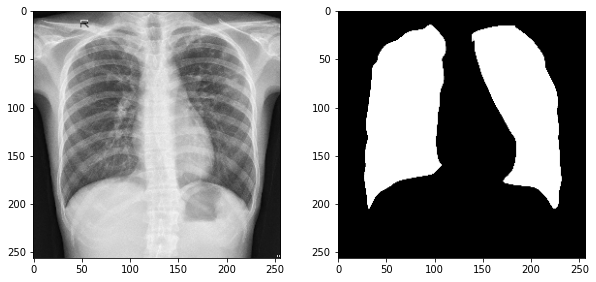

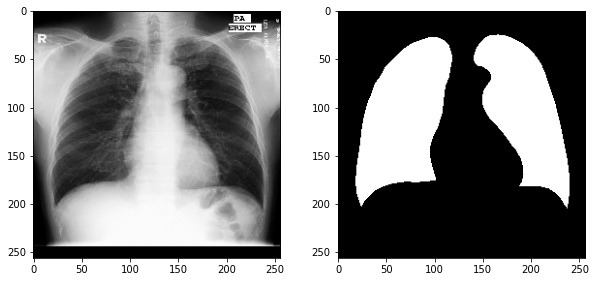

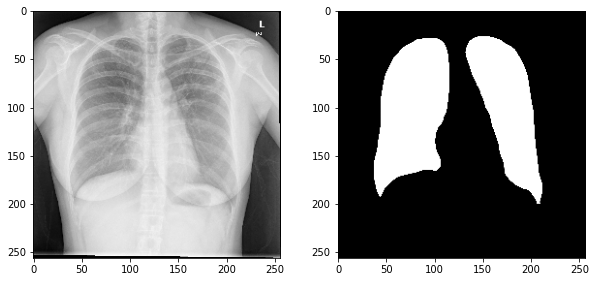

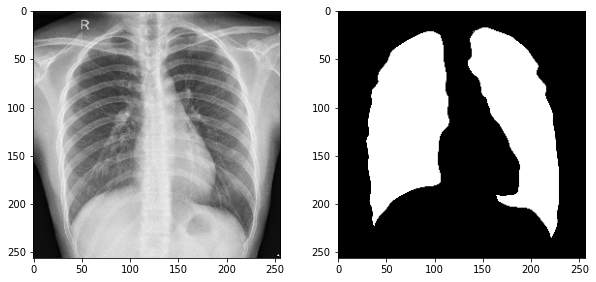

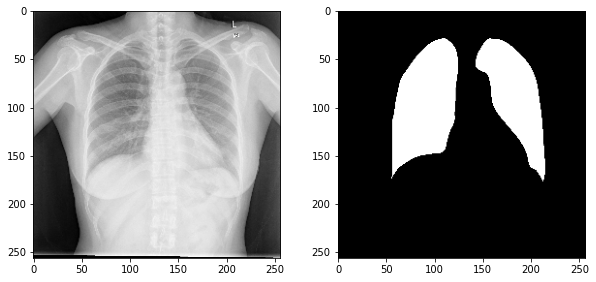

In [ ]:
# let us see some image-mask pairing
for i in range (5):


    fig = plt.figure(figsize = (10,10))
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(x_train[i], cmap = "gray")
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(y_train[i], cmap = "gray")

In [ ]:
# defining the image shape based on the pre-processing done above
input_shape = (256, 256, 3)

## Deep Learning Begins Here

This section is used to get to know more about the training of deep learning methods. We go through the steps of building a deep neural netweork, selecting the correct loss function and optimisers.

The model is then put through a training process and the ideal model is saved for the inference.

### Learning Targets-


*   Building Layers in a Deep Neural Network(DNN)
*   Selecting Hyperparameters for a Network
*   Training a DNN
*   Saving the trained DNN



In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import * 
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

In [ ]:
# to measure the overfitting of a model we create a training and validation set
# split the dataset into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)


In [ ]:
# defination of the deep learning based segmentor
def Segmenter(input_size=(256, 256, 1), latent_dim = 8):
    # Input Layer
    input_img = Input(shape=input_shape, name='encoder_input')
    
    # Encoder 
    x = Conv2D(16, (3, 3), padding='same', activation='relu')(input_img)
    x = Conv2D(32, (3, 3), padding='same', activation='relu',strides=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    conv_shape = K.int_shape(x) 
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)

    # Latent Space
    z = Dense(latent_dim, name='latent_vector')(x)
    
    # Decoder
    x = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(z)
    x = Dropout(0.1)(x)
    x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', activation='relu',strides=(2, 2))(x)
    output = Conv2DTranspose(1, (3, 3), padding='same', activation='sigmoid', name='decoder_output')(x)

    model = Model(inputs = input_img, outputs = output)
    # define the model optimiser, losses and metrics
    model.compile(optimizer = Adam(learning_rate= 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
# load the model
model = Segmenter(input_shape)
# model layer by layer summary
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
flatten_3 (Flatten)          (None, 2097152)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                6710

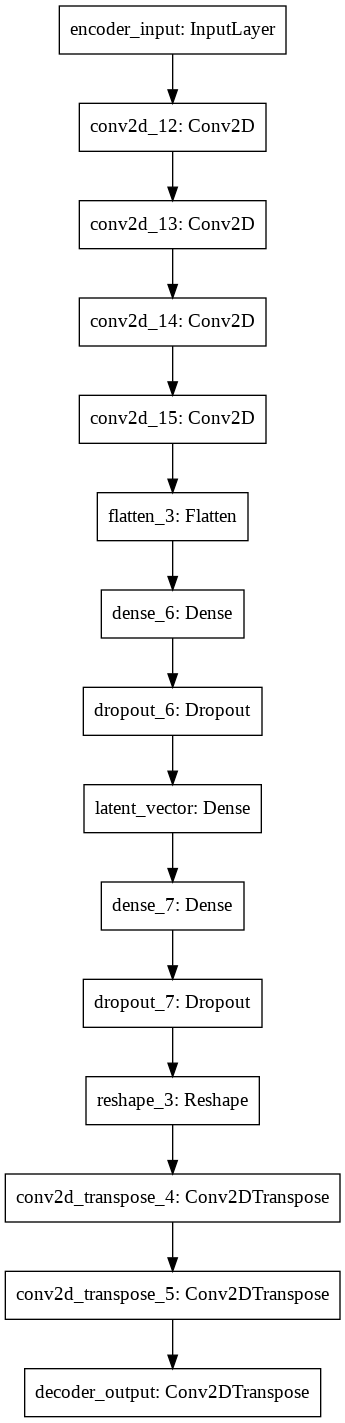

In [ ]:
# some more model viz
tf.keras.utils.plot_model(model, to_file="model.png")

In [ ]:
# early stopping to prevent overfitting
model_checkpoint = ModelCheckpoint("/content/trained_model.h5", monitor='loss',verbose=2, save_best_only=True)

# tain the model
history = model.fit(x = np.array(x_train), 
                    y = np.array(y_train), 
                    epochs = 1, 
                    batch_size = 32,
                    validation_data=(np.array(x_val), np.array(y_val)),
                    callbacks = [model_checkpoint])

Epoch 1/200
18/18 [==============================] - 23s 1s/step - loss: 0.5847 - accuracy: 0.7543 - val_loss: 0.3333 - val_accuracy: 0.8538

Epoch 00001: loss improved from inf to 0.58468, saving model to /content/trained_model.h5
Epoch 2/200
18/18 [==============================] - 19s 1s/step - loss: 0.2821 - accuracy: 0.8815 - val_loss: 0.2346 - val_accuracy: 0.8952

Epoch 00002: loss improved from 0.58468 to 0.28210, saving model to /content/trained_model.h5
Epoch 3/200
18/18 [==============================] - 19s 1s/step - loss: 0.2422 - accuracy: 0.8927 - val_loss: 0.2277 - val_accuracy: 0.8967

Epoch 00003: loss improved from 0.28210 to 0.24216, saving model to /content/trained_model.h5
Epoch 4/200
18/18 [==============================] - 19s 1s/step - loss: 0.2400 - accuracy: 0.8935 - val_loss: 0.2287 - val_accuracy: 0.8969

Epoch 00004: loss improved from 0.24216 to 0.23998, saving model to /content/trained_model.h5
Epoch 5/200
18/18 [==============================] - 19s 1s/

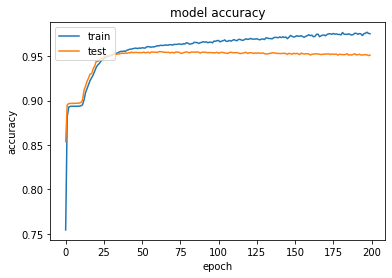

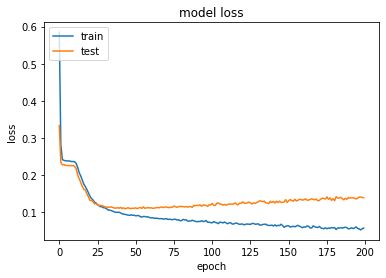

In [ ]:
# lets take a look how model training went

# plot training vs validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# plot training vs validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# Inference

This section is used to get to know how to use a trained a model to do inference. We go through the steps loading the pre-trained model and doing a prediction.

### Learning Targets-

*   Loading a trained model
*   Doing a inference on a Image



In [ ]:
# if your trained model is not good enough you can use a pre-trained model
! wget https://github.com/a-parida12/furry-octo-spork/raw/main/solution/trained_model.h5

--2021-09-29 08:11:16--  https://github.com/a-parida12/furry-octo-spork/raw/main/solution/trained_model.h5
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/a-parida12/furry-octo-spork/main/solution/trained_model.h5 [following]
--2021-09-29 08:11:16--  https://media.githubusercontent.com/media/a-parida12/furry-octo-spork/main/solution/trained_model.h5
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1035730512 (988M) [application/octet-stream]
Saving to: ‘trained_model.h5’

trained_model.h5    100%[===================>] 987.75M   161MB/s    in 5.9s    

2021-09-29 08:11:32 (166 MB/s

In [ ]:
# loading the model
pretrained_weights_path = "/content/trained_model.h5"
model = Segmenter(input_shape)

# adding weights from the pretrained model
model.load_weights(pretrained_weights_path)

In [ ]:
test_path_dir = os.path.join(data_path,"Lung Segmentation/test/")
test_images = os.listdir(os.path.join(data_path,"Lung Segmentation/test/"))

In [ ]:
# load the data and do the same preprocessing as the training data
x_test=[]
for i in range (len(test_images)):
    xray_num = i
    test_path = test_path_dir + test_images[xray_num]

    img = cv2.imread(test_path)
    img = cv2.resize(img,(256,256))
    x_test.append(img)
print (f"Image {i+1} added")

Image 95 added


In [ ]:
# inference
x_test= np.array(x_test)
y_pred=model.predict(x_test)

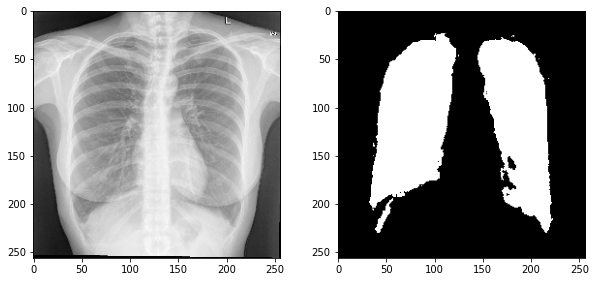

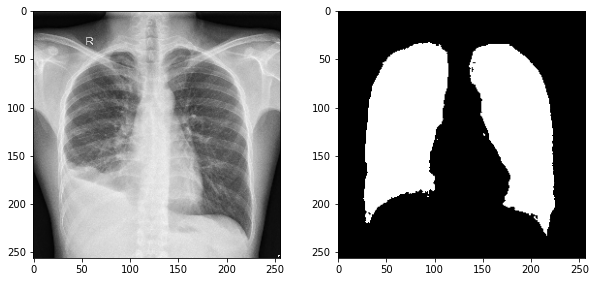

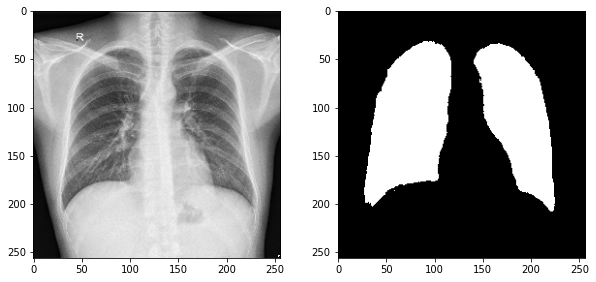

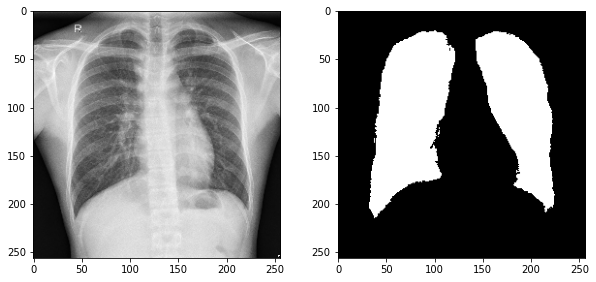

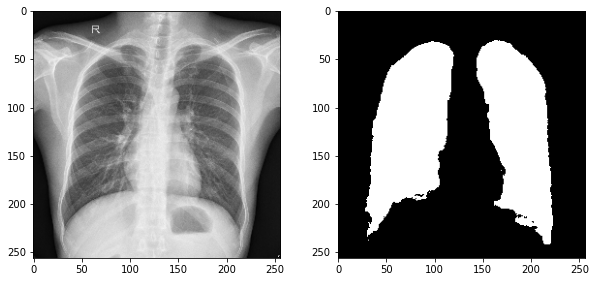

In [ ]:
# let us visualise the outputs for the test set
for i in range (15,20):
    fig = plt.figure(figsize = (10,10))

    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(x_test[i], cmap = "gray")
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(np.squeeze(y_pred[i]), cmap = "gray")